In [1]:
from dataclasses import replace

import darkdetect
import numpy as np
from matplotlib import pyplot as plt

from fit.matrices.const_mats import create_p2d_mat
from fit.matrices.top_mats import create_top_mats
from fit.mesh.box import Box, mesh_boxes
from fit.mesh.mesh import Mesh
from fit.plot.plot_vec import plot_vec
from fit.plot.plot_pot import plot_pot
from fit.solver.solve_poisson import solve_poisson
from fit.util.interpolate import interpolate_field, interpolate_flux

%load_ext autoreload
%autoreload 2

In [2]:
## matplotlib settings
if darkdetect.isDark():
    plt.style.use('dark_background')
else:
    plt.style.use('default')

plt.rcParams.update({
    "text.usetex": True
})

## Geometry
### 1) Mesh generation

In [3]:
n = 40
nz = 5
xmesh = np.linspace(0, 1, n)
ymesh = np.linspace(0, 1, n)
zmesh = np.linspace(0, 1, nz)
msh = Mesh(xmesh, ymesh, zmesh)

### 2) Material and geometric parameters

In [4]:
# Conductor
sig = 58e6                          # Conductivity          [S/m]
lam = 399/(8920*0.38)               # Thermal conductivity  [W/K*m]
n_thick = n / 5                     # Thick conductor width [-]
n_thin = n_thick / 2                # Thin conductor width  [-]

# Air
eps = 8.854e-12                     # Permittivity          [F/m]
sig_air = 1e-12                     # Conductivity          [S/m]
lam_air = 0.025/(1.225*1.005)       # Thermal conductivity   [W/K*m]

### 3) Material matrices

In [5]:
y0_idx = (int(msh.ny / 2 - n_thick), int(msh.ny / 2 + n_thick))    # y idx range of thick conductor
y1_idx = (int(msh.ny / 2 - n_thin), int(msh.ny / 2 + n_thin))      # y idx range of thin conductor

box_sig_0 = Box(sig, (0, int(msh.nx / 2)), y0_idx, (0, msh.nz))
box_sig_1 = Box(sig, (int(msh.nx / 2), msh.nx), y1_idx, (0, msh.nz))
box_lam_0 = replace(box_sig_0, value=lam)
box_lam_1 = replace(box_sig_1, value=lam)

sig_arr = mesh_boxes(msh, [box_sig_0, box_sig_1], sig_air)
lam_arr = mesh_boxes(msh, [box_lam_0, box_lam_1], lam_air)
m_sig = create_p2d_mat(msh, sig_arr)
m_lam = create_p2d_mat(msh, lam_arr)

m_eps = create_p2d_mat(msh, eps)

## Excitations
### 1) Boundary conditions

In [6]:
V0 = 0
V1 = 1e-6

box_bc_0 = Box(V0, (0, 1), y0_idx, (0, msh.nz))
box_bc_1 = Box(V1, (n - 1, n), y1_idx, (0, msh.nz))
bc = mesh_boxes(msh, [box_bc_0, box_bc_1], np.nan)

### 5) Current excitation - rhs

In [7]:
g,_,_ = create_top_mats(msh)
i = np.zeros(3*msh.np)
q = -g.T @ i

## Electrostatic system
### 1) Solve system

In [8]:
phi = solve_poisson(msh, q, m_sig, bc)

gmres terminated with exit code 0


### 2) Plot electric potential $\phi$

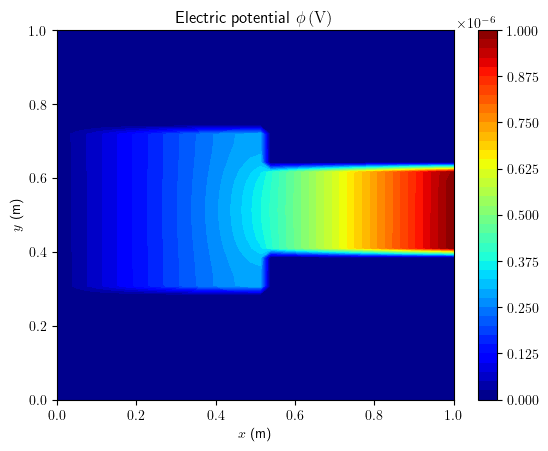

In [9]:
plot_pot(msh, phi, nz=2, levels=n, cmap='jet', title=r'Electric potential $\phi\,\mathrm{(V)}$')

## Post-processing
### 1) Plot electric field $\mathbf{E}$

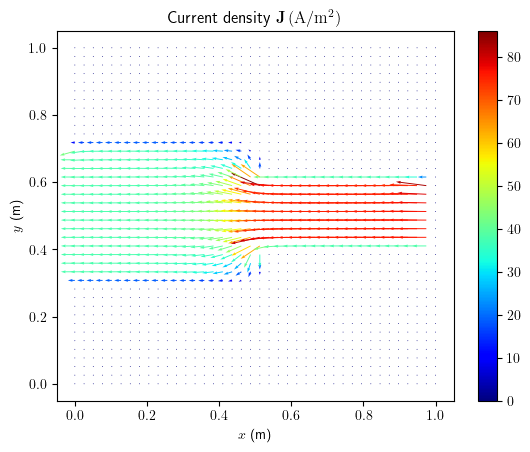

In [10]:
e = -g @ phi
j = m_sig @ e
plot_vec(msh, interpolate_flux(msh, j), nz=2, cmap='jet', title=r'Current density $\mathbf{J}\,\mathrm{(A/m^2)}$ ')

### 2) Calculate power

In [11]:
pe = e * j                  # Power on edge vector
pv = 0.5*np.abs(g.T) @ pe   # Power on dual volume vector

### 3) Plot power $P$

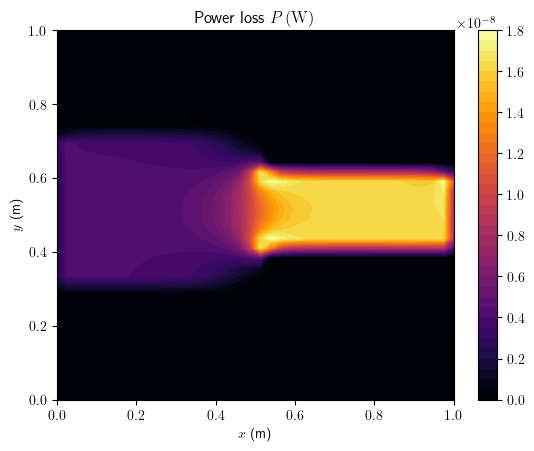

In [12]:
plot_pot(msh, pv, nz=2, levels=n, cmap='inferno', title='Power loss $P\,\mathrm{(W)}$')

## Thermal system
### 1) Boundary conditions

In [13]:
box_bc_0 = Box(0, (0, msh.nx), (0, 1), (0, msh.nz))
box_bc_1 = Box(0, (0, msh.nx), (n-1, n), (0, msh.nz))
bc = mesh_boxes(msh, [box_bc_0, box_bc_1], np.nan)

### 2) Solve system

In [14]:
theta = solve_poisson(msh, pv, m_lam, bc)

gmres terminated with exit code 8000


### 3) Plot temperature $\theta$

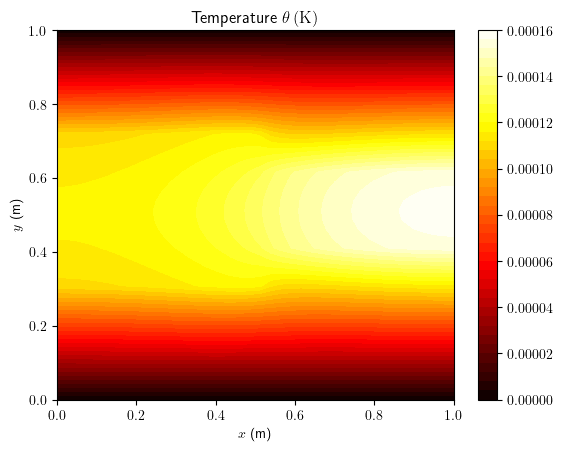

In [15]:
## Plot theta
plot_pot(msh, theta, nz=2, levels=n, cmap='hot', title=r'Temperature $\theta\,\mathrm{(K)}$')